---
title: "Generative AI: GANs"
description: "Part 4: Generative Adversarial Networks"
date: "2024-04-01"
# image: "deep_learning_model.png"
categories: [AI, Engineering, GenerativeAI, GAN]
format:
  html:
    code-fold: true
---

# GANs

Notes on Generative Adversarial Networks (GANs).

::: {.callout-tip title="Story Time"}
Imagine a forger trying to forge £20 notes and the popo trying to stop them.

The popo learn to spot the fakes.
But then the forger learns to improve their forging skills to make better fakes.

This goes back and forth. With each iteration, the forger keeps getting better but then the popo learn to spot these more sophisticated fakes.

The results in a forger (generator) learning to create convincing fakes and the popo (discriminator) learning to spot fakes.
:::


## 1. GANs
The idea of GANs is that we can train two competing models:

- The **generator** tries to convert random noise into convincing observations.
- The **discriminator** tries to predict whether an observation came from the original training dataset or is a "fake".

We initialise both as random models; the generator outputs noise and the discriminator predicts randomly.
We then alternate the training of the two networks so that the generator gets incrementally better at fooling the discriminator, then the discriminator gets incrementally better at spotting fakes.


```{mermaid}
flowchart LR

  A([Random noise]) --> B[Generator] --> C([Generated image]) 

  D([Image]) --> E[Discriminator] --> F([Prediction of realness probability])
```



## 2. Building a Deep Convolutional GAN (DCGAN)
We will implement a GAN to generate [pictures of bricks](https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images).

### 2.1. Load and pre-process the data
Load image data of lego bricks. We will train a model that can generate novel lego brick images.


#### tanh vs sigmoid activation
The original data is scaled from [0, 255].

Often we will rescale this to [0, 1] so that we can use sigmoid activation functions.

In this case we will scale to [-1, 1] so that we can use tanh activation functions, which tend to give stronger gradients than sigmoid.


In [11]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)


def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display_images(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """Displays n random images from each one of the supplied arrays."""
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

Model and data parameters:

In [14]:
DATA_DIR = Path("/Users/gurpreetjohl/workspace/datasets/lego-brick-images")

IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

Load and pre-process the training data:

In [17]:
def preprocess(img):
    """Normalize and reshape the images."""
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


training_data = utils.image_dataset_from_directory(
    DATA_DIR / "dataset",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)
train = training_data.map(lambda x: preprocess(x))

Found 40000 files belonging to 1 classes.


Some sample input images:

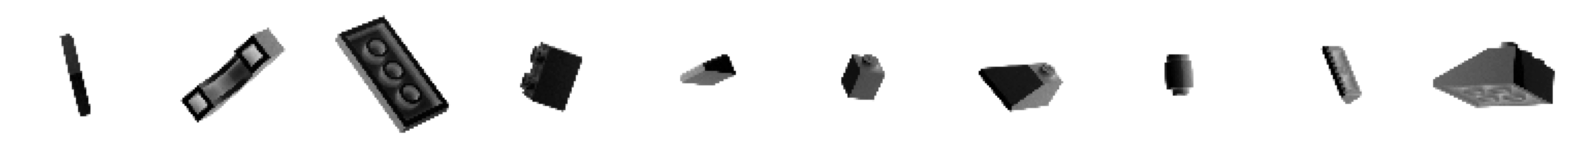

In [20]:
display_images(sample_batch(train))

### 2.2. Build the Discriminator

The goal of the discriminator is to predict whether an image is real or fake. 

This is a supervised binary classification problem, so we can use CNN architecture with a single output node. We stack `Conv2D` layers with `BatchNormalization`, `LeakyReLU` and `Dropout` layers sandwiched between.

In [22]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(discriminator_input)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1, kernel_size=4, strides=1, padding="valid", use_bias=False, activation="sigmoid")(x)
discriminator_output = layers.Flatten()(x)  # The shape is already 1x1 so no need for a Dense layer after this

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization_3 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                           

### 2.3. Build the Generator

The purpose of the generator is to turn random noise into convincing images.

The input is a vector sampled from a multivariate Normal distribution, and the output is an image of the same size as the training data.

The discriminator-generator relationship in a GAN is similar to that of the encoder-decoder relations in a VAE.

The architecture of the discriminator is similar to the discriminator but *in reverse* (like a decoder). We pass stack `Conv2DTranspose` layers with `BatchNormalization` and `LeakyReLU` layers sandwiched in between.

#### Conv2DTranspose

We use `Conv2DTranspose` layers to scale the image size up. 

An alternative would be to use stacks of `Upsampling2D` and `Conv2D` layers, i.e. the following serves the same purpose as a `Conv2DTranspose` layer:
```python
x = layers.Upsampling2D(size=2)(x)
x = layers.Conv2D(256, kernel_size=4, strides=1, padding="same")(x)
```

The `Upsampling2D` layer simply repeats each row and column to double its size, then Conv2D applies a convolution.

The idea is similar with `Conv2DTranspose`, but the extra rows and columns are *filled with zeros* rather than repeated existing values.

`Conv2DTranspose` layers can result in checkerboard pattern artifacts. Both options are used in practice, so it is often helpful to experiment and see which gives better results.

In [23]:
generator_input = layers.Input(shape=(Z_DIM,))

x = layers.Reshape((1, 1, Z_DIM))(generator_input)  # Reshape the input vector so we can apply conv transpose operations to it

x = layers.Conv2DTranspose(512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same", use_bias=False)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)

generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_6 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

### 2.4. Train the GAN
Alternate not simultaneously.

In [24]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [25]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [26]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/300
  4/313 [..............................] - ETA: 7:39 - d_loss: 0.3834 - d_real_acc: 0.8125 - d_fake_acc: 0.7051 - d_acc: 0.7588 - g_loss: 1.5256 - g_acc: 0.2949

## 3. Analysing the GAN



## 4. GAN Training Tips


## 5. Wasserstein GAN with Gradient Penalty (WGAN-GP)

### 5.1. Wasserstein Loss

### 5.2. Lipschitz Constraint

### 5.3. Gradient Penalty Loss

### 5.4. Training the WGAN-GP

### 5.5. Analysing the WGAN-GP


## 6. Conditional GAN (CGAN)

### 6.1. CGAN Architecture


## References

- Chapter 4 of Generative Deep Learning by David Foster.
